In [1]:
cat('Last updated ', date())

Last updated  Sun Oct 16 12:18:26 2022

# Clinical Trial Data analysis using R and SAS
### Author : Ding-Geng (Din) Chen , Karl E. Peace, Pinggao Zhang

* Note : This note book is created with R in Jupyter Notebook.
* Note : I made this note book while studying the book. Additional R code in addition to the book is added if necessary such that a code is not provided or addntional explanation is needed.  For detail explanation, refer the book. 

In [2]:
R.version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          1.3                         
year           2022                        
month          03                          
day            10                          
svn rev        81868                       
language       R                           
version.string R version 4.1.3 (2022-03-10)
nickname       One Push-Up                 

## Chapter 9 Bayesian Methods in Clinical Trials

### 9.3 MCMC Simulations

#### 9.3.1 Normal-Normal Model

Normal Distribution with Known Variance with $\mu = 3$ and $\sigma =2 $

In [29]:
set.seed(123)
n <- 30
sigma <- 2; mu <- 3
y <- rnorm(n, mu, sigma)
mean(y)
var(y)

[1] 2.905792

[1] 3.849685

Suppose we know the prior distribuion is normal with mean $\mu_0=2 $ and standard deviation $\tau_0=0.5$. Then the posterior distribution is also normal with poserior mean $\mu_p = \omega\bar{y} + (1-\omega)\theta_0$ and the posterior variance $\sigma^2_p= \frac{1}{\frac{n}{\sigma^2}+\frac{1}{\tau^2}}$, where $\omega=\frac{\tau^2}{\tau^2+\frac{\sigma^2}{n}}$

__Note: The conjugate prior__ <br>

The conjugate prior is a prior distribution when combined with the likelihood leads to the same distribution. <br> In the normal case, the conjugate prior is $\pi(\theta) = N(\theta_0, \tau^2)$ where $\theta_0$ and $\tau^2$ are the prior mean and variance, which leads to the posterior normal distribution.
$$p(\theta|y) \propto N(\mu_p, \sigma^2_p)$$
Where 
* The posterior mean is $\mu_p  = \omega\bar{y} + (1-\omega)\theta_0 $ and
* The posterior variance is $\sigma^2_p= \frac{1}{\frac{n}{\sigma^2}+ \frac{1}{\tau^2}}$

The posterior variance $\sigma^2_p$ incorporates variance from both the data and the prior distribution. And it is less than $\sigma^2/n$, representing a shrinkage to the posterior mean.


In [30]:
# the prior parameters
mu0<-2 ; tau0 <- 5

# the weight
w <- tau0^2 / (tau0^2 + sigma^2 /n)

# the posterior mean
muP <- w*mean(y) + (1-w)*mu0

# the posterior standard deviation
sigmaP <- sqrt(1/(1/tau0*2 + n/sigma^2))

# direct simulation of posterior normal
Bayes1.norm2norm <- rnorm(10000, muP, sigmaP)

We simulate 100,000 samles and name the resulting dataset in Bayes1.norm2norm.

In [18]:
quantile(Bayes1.norm2norm, c(0.025,0.25,0.5,0.75,0.975))

2.5%      25%      50%      75%    97.5% 
2.197506 2.663553 2.896929 3.140832 3.596074

We can also call the __MCnormalnormal__ function in MCMCpack for this simulation as follow.

In [19]:
# install.packages('MCMCpack')

In [31]:
library(MCMCpack)

In [32]:
# call the function
Bayes2.norm2norm <- MCMCpack::MCnormalnormal(y, sigma^2, mu0, tau0^2, 10000)

# print the summary
summary(Bayes2.norm2norm)


Iterations = 1:10000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      2.897671       0.364749       0.003647       0.003647 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
2.189 2.654 2.894 3.146 3.614 


__Figure 9.1__Distribution of Prior, Direct Simulation, and MCnormal-normal

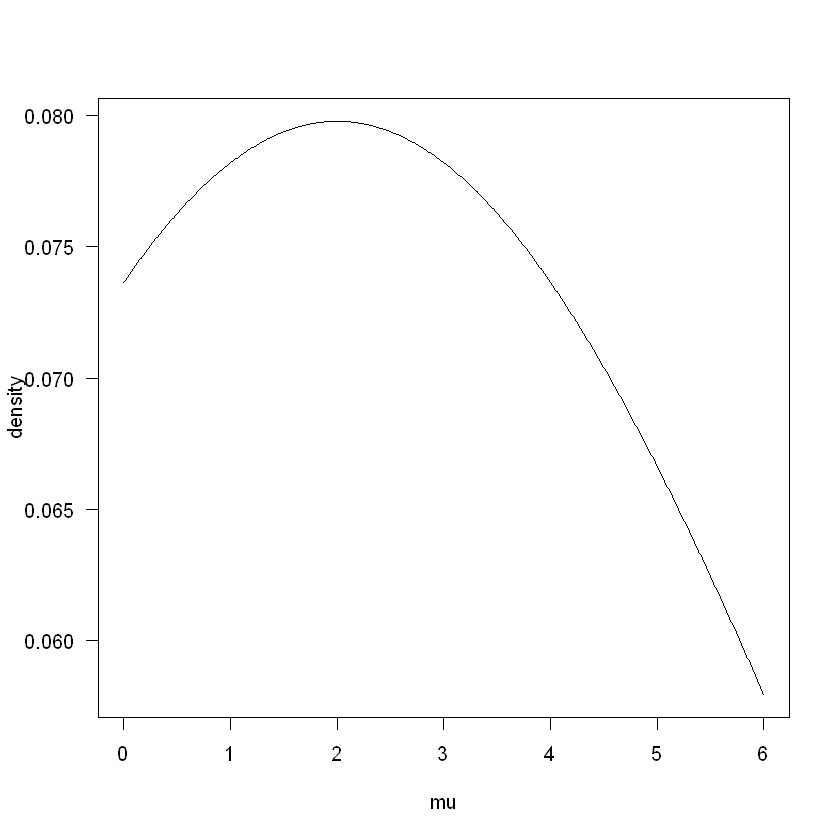

In [70]:
# Create x sequence
x = seq(0,6,0.01)

# plot the densities
plot(x, dnorm(x, mu0,tau0), type="l", lwd=1,las=1 , xlab="mu", ylab="density")

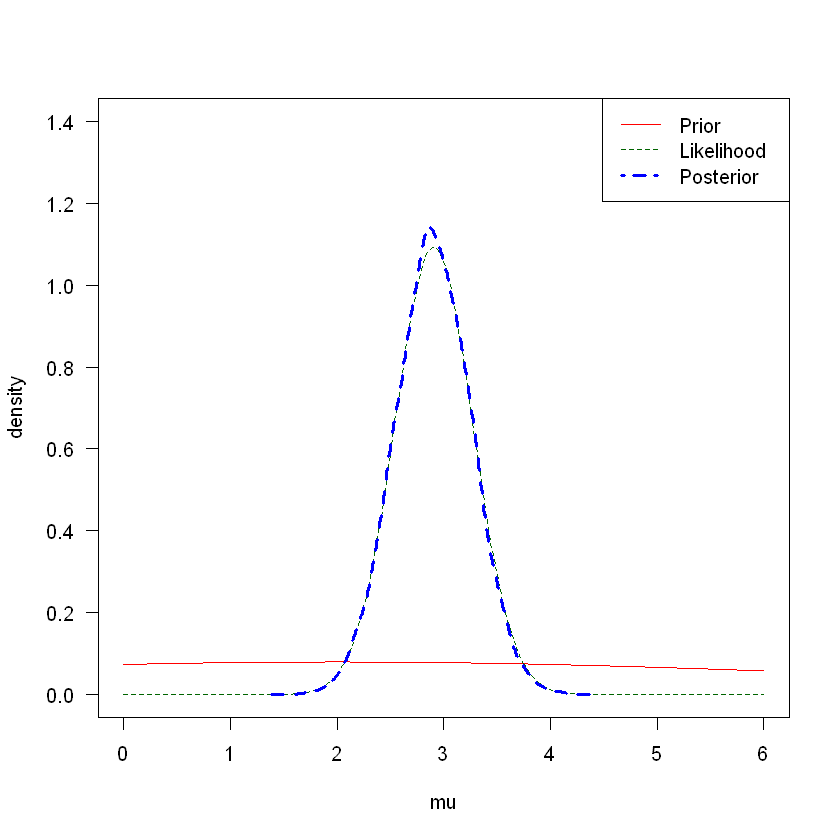

In [71]:
# Create x sequence
x = seq(0,6,0.01)

# plot the densities
plot(x, dnorm(x, mu0,tau0), type="l", lwd=1,las=1, ylim=c(0,1.4), xlab="mu", ylab="density", col='red')
lines(x, dnorm(x, mean(y), sigma/sqrt(n)), lty=8, lwd=1, col='darkgreen')
lines(density(Bayes1.norm2norm), lty=8, lwd=3, col='blue')

legend("topright", c("Prior","Likelihood", "Posterior"), lwd=c(1,1,3), lty=c(1,8,4), col=c ('red', 'darkgreen', 'blue'))

#### 9.3.2 Beta-Binomial Model

The beta-binomial distribution is commly used in Bayesian analysis of clinical trial data. The beta-binomial distribution results from binomial distributed data with a beta conjugate prior on the binomial probability parameter leading to a new (posterior) beta distribution. 

__Data__: the duodenal ulcer trial
* 800 mg C treatment was clinically optimal among the four treatments.
* A total of 168, 182, 165 and 188 patients were randomly entered in the 0 mg C, 400 mg C, 800 mg C, 1600 mg C treatment groups repectively. 
* The corresponding cumulative numbers of patients whose ulcers healed by the end of week 4 were 69, 113, 120, and 145 repectively.



The number of patients | 0 mg C | 400 mg C | 800 mg C |1600 mg C
--- | --- | --- | --- | ---
 Entered in treatment groups | 168 | 182 | 165 | 188
Ulcers healed | 69 | 113 | 120 | 145 
P | $\frac{69}{168}$ | $\frac{113}{182}$ |$\frac{120}{165}$ | $\frac{145}{188}$
|<img width=10/>|<img width=10/>|<img width=10/>|<img width=10/>

In [89]:
# total patients for each treatment
n <-  c(168, 182, 165,188)


# number healed
x <- c(69, 113, 120, 145)

# the observed proportion
p <- x/n

p


[1] 0.4107143 0.6208791 0.7272727 0.7712766

Consider the 800 mg C treatment where we observed that $x_3=120$ of $n_3=165$ patients had their ulcers healed. $x_3$ is binomially distributed with the probability $p_3$ eatimated as $\hat{p_3}=\frac{x_3}{n_3}=\frac{120}{165}=0.73$ <br>

The likelihood is 
$L(p) \propto p^{x_3}(1-p)^{n_3-x_3}$

For Bayesian Inference, we need to identify a suitable prior for the cumulative 4-week healing rate p. We could use the noninformative prior where the posterior distribution would be the same as the likelihoo.

However, we illustrate a __simple approach__ to derive an __informative prior__.

Suppose that the median of the distribution of p is about 0.75 and the 95 percentile is 0.85 for this treatment. We can build a search algorithm to find values to be used for the prior parameters a and b.

In [84]:
# the objective function
obj <- function(parm){
a = parm[1]; b = parm[2]
(pbeta(0.50,a,b) -0.75)^2 + (pbeta(0.95,a,b)- 0.85)^2
}

# pbeta: probability of the Beta Distribution

We use _optim_ to optimize (in this case, minimize) the objective function to find (a,b).

In [90]:
# call optim to search the root with initial values at (3,3)
out <- optim(c(3,3), obj)
print(out)

Warning message in pbeta(0.5, a, b):
"NaNs produced"
Warning message in pbeta(0.95, a, b):
"NaNs produced"
Warning message in pbeta(0.5, a, b):
"NaNs produced"
Warning message in pbeta(0.95, a, b):
"NaNs produced"


$par
[1] 0.06211388 0.18292668

$value
[1] 2.571625e-10

$counts
function gradient 
     119       NA 

$convergence
[1] 0

$message
NULL



Note that this search is a local on and there are many roots to be found depending on where the search is started. 
We use a=0.0062 and b=0.183 from this search as the prior parameters for our beta prior. 

In [92]:
# the median of beta dist with a=0.0062 and b=0.183
pbeta(0.5,out$par[1], out$par[2])

[1] 0.7499841

In [91]:
# the 95% percentile of beta dist with a=0.0062 and b=0.183
pbeta(0.95,out$par[1], out$par[2])

[1] 0.8500024

Based on this prior, the posterior distribution for the cumulative 4-week healing rate is

$$\begin{eqnarray} 
p(p|n_3,x_3) &\propto& L(p) \times  \pi(p) \\
            &=& p^{x_3}(1-p)^{n_3-x_3}\times p^{a-1}(1-p)^{b-1}\\
            &=&p^{x_3+a-1}(1-p)^{n_3-x_3+b-1}
\end{eqnarray}$$

which is $beta(x_3+a,n_3-x_3+b)
=beta(120+0.062, 165-120+0.183)=beta(120.062, 45.183)$

We now use this posterior distribution for 10,000 simulations.

__Note__

Now we assume that $y \sim Binomial(n, \theta)$ with $\theta$ is tha binomial proportion parameter

The conjugate prior Beta(a,b) as $\pi(\theta) \propto \theta^{a-1}(1-\theta)^{b-1}$.

The posterior distribution can be
$p(\theta|y)= Beta(a+y, b+n-y)$ 

In [93]:
# direct simulation
Bayes1.betabin = rbeta(10000, 120.062, 45.183)

# print the quantiles
quantile(Bayes1.betabin, c(0.025,0.25,0.5,0.75,0.975))

2.5%       25%       50%       75%     97.5% 
0.6561081 0.7036960 0.7271225 0.7500809 0.7906585

In [79]:
# keep the parameters
x3 = 120; n3 =165; a = 0.062; b=0.183

# call the MCbinomialbeta function for 10000 simulation
Bayes2.betabin = MCbinomialbeta(x3, n3, a, b, mc=10000)

# print the summary
summary(Bayes2.betabin)


Iterations = 1:10000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.7262305      0.0347453      0.0003475      0.0003475 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6557 0.7033 0.7269 0.7497 0.7921 


We can emply the _MCbinomialbeta_ function from the MCMCpack package for the same purpose. This function is for Monte Carlo simulation from a binomial likelihood with a beta prior.

In [94]:
# keep the parameters
x3 = 120; n3 =165; a = 0.062; b=0.183

# call the MCbinomialbeta function for 10000 simulation
Bayes2.betabin = MCbinomialbeta(x3, n3, a, b, mc=10000)

# print the summary
summary(Bayes2.betabin)


Iterations = 1:10000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.7261329      0.0346258      0.0003463      0.0003463 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6563 0.7030 0.7272 0.7499 0.7912 


__Figure 9.2__: Distributions of Prior, Direct Simulaion, and MCbinomial-beta

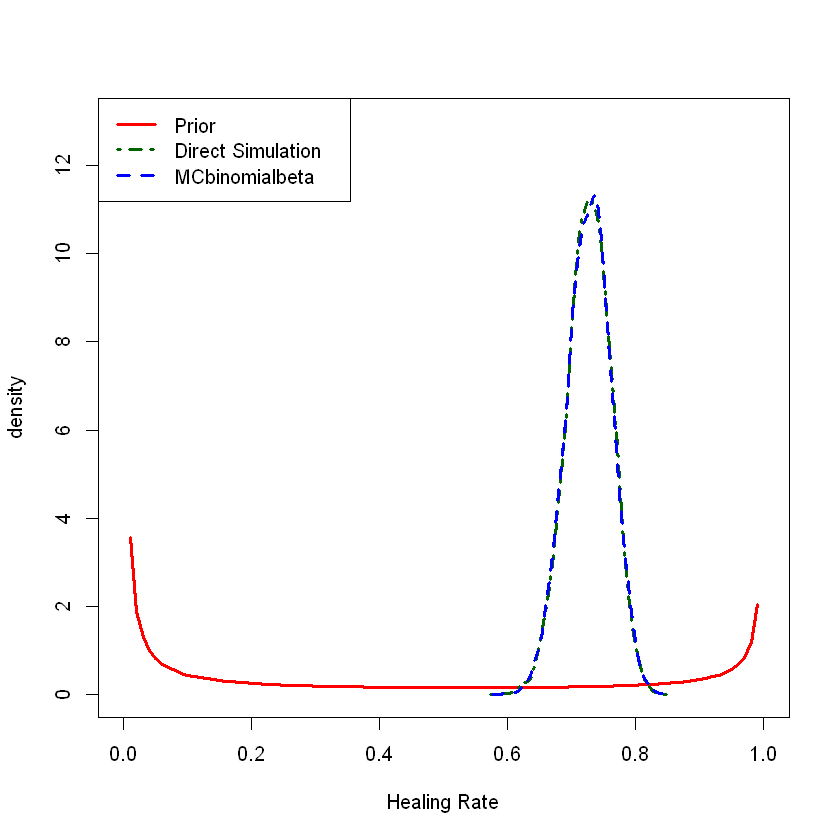

In [95]:
# create a sequence for p for plotting
p = seq(0,1,0.01)

# plot beta-density
plot(p, dbeta(p,a, b), lwd=3, type="l",ylim=c(0,13),
xlab="Healing Rate", ylab="density", col='red')

# Add lines to the density
lines(density(Bayes1.betabin), lty=4, lwd=3, col='darkgreen')
lines(density(Bayes2.betabin), lty=8, lwd=3, col='blue')

# add legend to the plot
legend("topleft", c("Prior", "Direct Simulation",
"MCbinomialbeta"), lwd=3, lty=c(1,4,8), col=c('red','darkgreen', 'blue'))

In this fiture, the direct simulation and MCbinomialgeta are almost identical.